In [1]:
""" This Script creates a 3D world map with the locations of organizations based on their geocodes"""

' This Script creates a 3D world map with the locations of organizations based on their geocodes'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("../Data/organizations_map.csv")

# Drop duplicate values if existing
df = df.drop_duplicates(subset=['Linkedin_name','city'])

In [2]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, box

""" DEFINE FUNCTION TO CREATE GRIDS FOR LOCATIONS"""

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.latitude, df.longitude), crs="EPSG:4326")

# Define a function to generate a grid
def generate_grid(cell_size_km=50):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    x_min, y_min, x_max, y_max = world.total_bounds
    rows = int(np.ceil((y_max-y_min) / (cell_size_km / 111))) # 111 km is approx. distance of 1 degree lat in most places
    cols = int(np.ceil((x_max-x_min) / (cell_size_km / 111)))

    grids = []
    for i in range(rows):
        for j in range(cols):
            min_x = x_min + (cell_size_km / 111) * j
            max_x = x_min + (cell_size_km / 111) * (j+1)
            min_y = y_min + (cell_size_km / 111) * i
            max_y = y_min + (cell_size_km / 111) * (i+1)
            grids.append(box(min_x, min_y, max_x, max_y))

    grid_gdf = gpd.GeoDataFrame(grids, columns=['geometry'], crs="EPSG:4326")
    return grid_gdf

grid_gdf = generate_grid(cell_size_km=50)

# Spatially join points with the grid and count
join = gpd.sjoin(gdf, grid_gdf, how="right", op="within")
join = join.dropna(subset=['Linkedin_name'])
count = join.groupby('geometry').size().reset_index(name='count')

print(join)
# Merge the counts with grid for plotting
grid_gdf = grid_gdf.merge(count, left_on="geometry", right_on="geometry").fillna(0)

/var/folders/pq/_r_xc3wx2t79gmb10j_gbz_8043sw5/T/ipykernel_75798/2829974615.py:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/Users/go76niy/Documents/GitHub/ClimateTech_Innovation_Networks_Code/venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3612: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


        index_left  Unnamed: 0                           Linkedin_name  \
21569      50996.0     69088.0                  antarctica-new-zealand   
38172      10186.0     17740.0                                   43865   
62647     305853.0    379777.0            gobierno-de-tierra-del-fuego   
62647      73326.0     95674.0                                 globant   
62647     127936.0    161823.0                             shiftcities   
...            ...         ...                                     ...   
298834     48586.0     65668.0                   hurtigrutensvalbardas   
298834    161467.0    204065.0            kongsberg-satellite-services   
298834     13536.0     24313.0                                 where2o   
298834    194572.0    244917.0  store-norske-spitsbergen-kulkompani-as   
298834    132953.0    168566.0           university-centre-in-svalbard   

                                   sector  latitude  longitude country  \
21569                       Other Sec

/var/folders/pq/_r_xc3wx2t79gmb10j_gbz_8043sw5/T/ipykernel_75798/3758985790.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


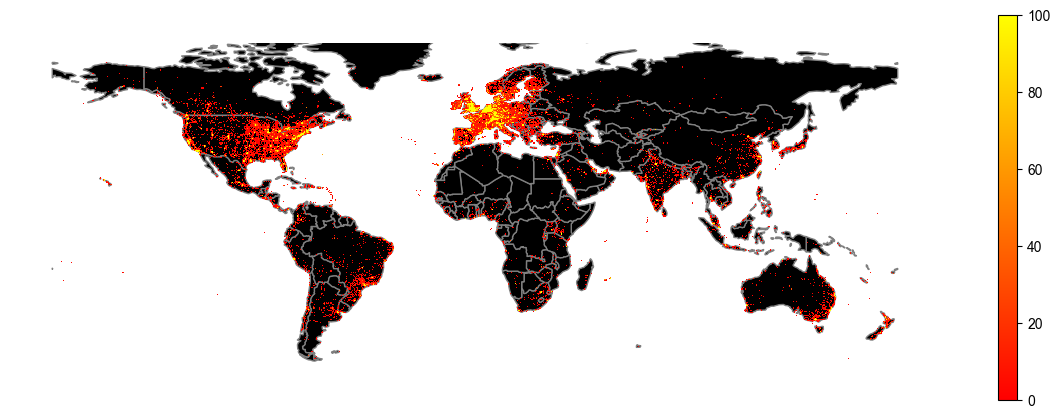

In [3]:
""" 2D Heatmap"""
# Plotting
plt.rcParams['font.family'] = "Arial"
plt.rcParams['figure.figsize'] = (10, 6)
fig, ax = plt.subplots(figsize=(15, 10))




# Plot world boundaries as a background
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, linewidth=1, color='black', edgecolor="gray", zorder=0)
# Plot the grid
plot = grid_gdf.plot(column='count', ax=ax, legend=True, cmap='autumn', vmin=0, vmax = 100, legend_kwds={'shrink': 0.5})#cmap='viridis'
#ax.set_xlim([-1.4e7, 1.5e7])



ax.set_ylim([-60, 80])
ax.set_axis_off()
plt.show()
fig.savefig('heatmap.png', dpi=300, bbox_inches='tight')

/var/folders/pq/_r_xc3wx2t79gmb10j_gbz_8043sw5/T/ipykernel_75798/2903166972.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['x'] = grid_gdf.geometry.centroid.x
/var/folders/pq/_r_xc3wx2t79gmb10j_gbz_8043sw5/T/ipykernel_75798/2903166972.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['y'] = grid_gdf.geometry.centroid.y


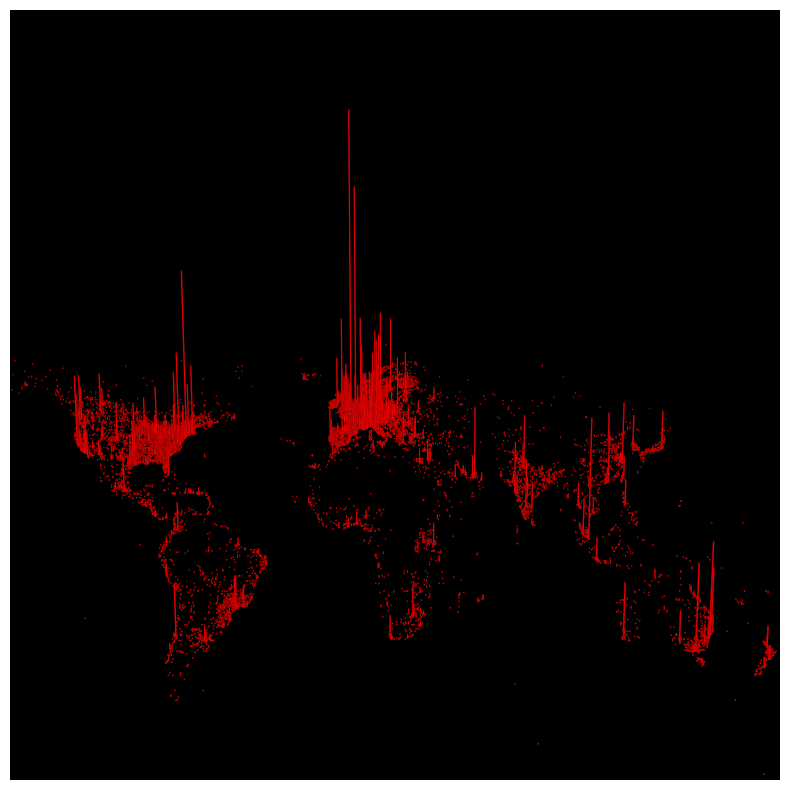

In [4]:
""" 3D Map"""

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# Assuming grid_gdf is already created with 'count' column representing the number of firms

# Define midpoints of each grid for bar positioning
grid_gdf['x'] = grid_gdf.geometry.centroid.x
grid_gdf['y'] = grid_gdf.geometry.centroid.y

# Set up the figure and 3D axis
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Remove the grid (the white lines that denote units on the axes)
ax.grid(False)

ax.set_xlim([-80, 130])
ax.set_ylim([-45, 50])

# Remove the axis lines, ticks, and labels
ax.set_axis_off()

# Define width, depth, and height of bars
dx = dy = 0.5  # Adjust based on your grid size and desired appearance
dz = grid_gdf['count'].values

# Set background color
ax.set_facecolor('black')

# Create a 3D bar plot with red bars
ax.bar3d(
    x=grid_gdf['x'],
    y=grid_gdf['y'],
    z=np.zeros_like(dz),
    dx=dx,
    dy=dy,
    dz=dz,
    shade=True,
    color='red'  # Explicitly set the bar color
)


# Adjust the viewpoint of the 3D plot
ax.view_init(elev=30, azim=-90)  # Modify these values as per your requirements

#save figure as png
fig.savefig('3d_map_new.png', dpi=300, bbox_inches='tight')